# General Transfer Matrix (GTM) Formalism Scattering

In this example static light scattering simulations are carried out employing a dynamical general transfer matrix formalism which was adapted from [pyGTM](https://pygtm.readthedocs.io).

## Setup

Do all necessary imports and settings.

In [1]:
import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib()  # use matplotlib with pint units

## Structure

Refer to the [structure-example](structure.ipynb) for more details.

In this example the sample `Structure` consists of `Layer`s.

In [2]:
layer_air = ud.AmorphousLayer('air', "air", 1*u.um, 0*u.kg/u.m**3)
layer_glass = ud.AmorphousLayer('glass', "glass", 1*u.um, 0*u.kg/u.m**3)
layer_Au = ud.AmorphousLayer('Au', "gold", 50*u.nm, 0*u.kg/u.m**3)

### Set the dielectric function

In [3]:
layer_air.epsilon = 1-0j
layer_glass.epsilon = 1.5**2-0j

In [4]:
def eps_Au(f):
    """
    Gold (Au) permittivity. 

    :param array f: frequency (array or float)
    :return: permittivity (float or len(f)-array)

    **Attention**, two models are used: a simple Drude model with parameters 
    from `Derkachova et al., Plasmonics 11, 941 (2016) (open access) 
    <http://doi.org/10.1007/s11468-015-0128-7>`_ 
    or the tabulated data from Jonhson and Christy 
    (`refractiveindex.info <https://refractiveindex.info/?shelf=main&book=Au&page=Johnson>`_)
    You should check carefully if this works out for you. 
    """
    f = np.array(f)
    import scipy.constants as constants
    c_const = constants.physical_constants['speed of light in vacuum'][0]
    fmin_JC = c_const/1.93e-6
    fmax_JC = c_const/0.188e-6

    #print('Using Jonhson and Christy data for Au')
    epsAufile = './Au_Johnson_nk.csv'
    eps_loaded = np.genfromtxt(epsAufile, delimiter='\t',
                               skip_header=1, unpack=True)

    lbda = eps_loaded[0, :]*1e-6
    n = eps_loaded[1,:]
    k = eps_loaded[2,:]
    eps1 = n**2-k**2
    eps2 = 2*n*k
    floc = c_const/lbda
    epsr = np.interp(f, floc[::-1], eps1[::-1])
    epsi = np.interp(f, floc[::-1], eps2[::-1])

    return epsr+1.0j*epsi

In [5]:
layer_Au.epsilon = eps_Au

In [6]:
S = ud.Structure('Optical Sample')

S.add_sub_structure(layer_air, 1)
S.add_sub_structure(layer_glass, 1)

## Initialize general transfer matrix simulations

The `GTM` class requires a `Structure` object and a boolean `force_recalc` in order overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can using the boolean switch `progress_bar`.

In [7]:
gtm = ud.GTM(S, True)
gtm.disp_messages = False
gtm.save_data = False

### set simulation parameters

In [8]:
gtm.wl = np.r_[600]*u.nm #  set two photon energies
gtm.theta =  np.r_[1:80:0.1]*u.deg

do the actual calculations

In [9]:
r, R, t, T = gtm.calculate_r_t()

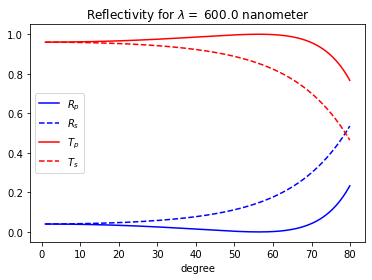

In [10]:
plt.figure()
plt.plot(gtm.theta[0, :], R[0, :, 0], '-b', label=r'$R_p$')
plt.plot(gtm.theta[0, :], R[0, :, 1], '--b', label=r'$R_s$')
plt.plot(gtm.theta[0, :], T[0, :, 0], '-r', label=r'$T_p$')
plt.plot(gtm.theta[0, :], T[0, :, 1], '--r', label=r'$T_s$')
plt.legend()
plt.title('Reflectivity for $\lambda = $ {:0.1f}'.format(gtm.wl[0]))
plt.show()

build new sample

In [11]:
gtm.wl = np.r_[400:800:1]*u.nm #  set two photon energies
gtm.theta =  np.r_[1:80:0.5]*u.deg

c:\users\loc_schick\general\git\udkm1dsim\udkm1Dsim\simulations\scattering.py:258: RuntimeWarning: invalid value encountered in arcsin
  self._theta = np.arcsin(np.outer(self._wl, self._qz[0, :])/np.pi/4)


In [12]:
S = ud.Structure('Optical Sample Gold')

S.add_sub_structure(layer_glass, 1)
S.add_sub_structure(layer_Au, 1)
S.add_sub_structure(layer_air, 1)
gtm.S =S

In [13]:
r, R, t, T = gtm.calculate_r_t()

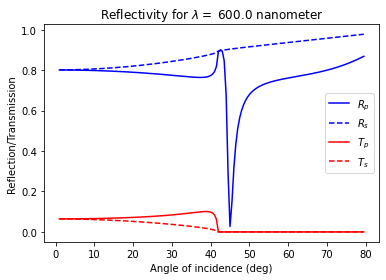

In [14]:
index = 200
plt.figure()
plt.plot(gtm.theta[index, :], R[index, :, 0], '-b', label=r'$R_p$')
plt.plot(gtm.theta[index, :], R[index, :, 1], '--b', label=r'$R_s$')
plt.plot(gtm.theta[index, :], T[index, :, 0], '-r', label=r'$T_p$')
plt.plot(gtm.theta[index, :], T[index, :, 1], '--r', label=r'$T_s$')
plt.legend()
plt.title('Reflectivity for $\lambda = $ {:0.1f}'.format(gtm.wl[index]))
plt.xlabel('Angle of incidence (deg)')
plt.ylabel('Reflection/Transmission')
plt.show()

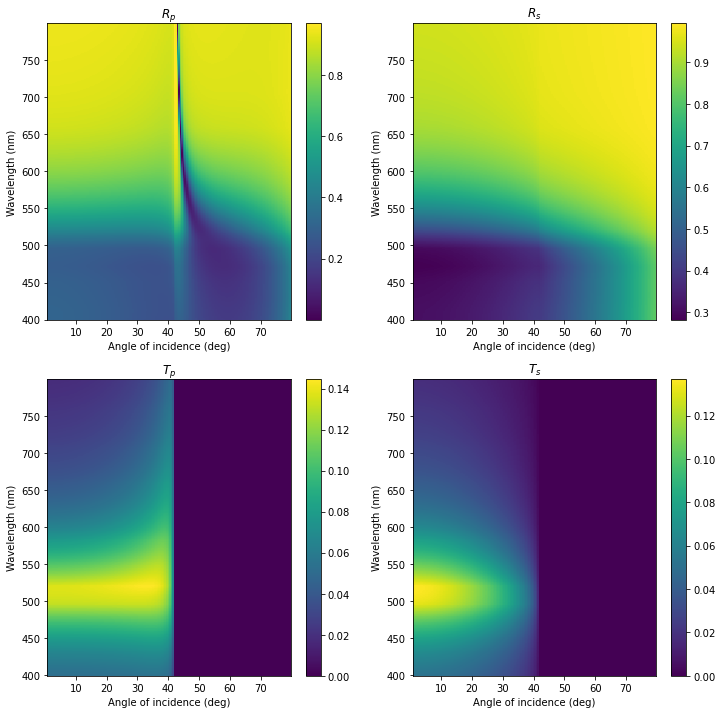

In [15]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.pcolormesh(gtm.theta[0, :].magnitude, gtm.wl.magnitude, R[:, :, 0], shading='auto')
plt.colorbar()
plt.title(r'$R_p$')
plt.xlabel('Angle of incidence (deg)')
plt.ylabel('Wavelength (nm)')

plt.subplot(2,2,2)
plt.pcolormesh(gtm.theta[0, :].magnitude, gtm.wl.magnitude, R[:, :, 1], shading='auto')
plt.colorbar()
plt.title(r'$R_s$')
plt.xlabel('Angle of incidence (deg)')
plt.ylabel('Wavelength (nm)')

plt.subplot(2,2,3)
plt.pcolormesh(gtm.theta[0, :].magnitude, gtm.wl.magnitude, T[:, :, 0], shading='auto')
plt.colorbar()
plt.title(r'$T_p$')
plt.xlabel('Angle of incidence (deg)')
plt.ylabel('Wavelength (nm)')

plt.subplot(2,2,4)
plt.pcolormesh(gtm.theta[0, :].magnitude, gtm.wl.magnitude, T[:, :, 1], shading='auto')
plt.colorbar()
plt.title(r'$T_s$')
plt.xlabel('Angle of incidence (deg)')
plt.ylabel('Wavelength (nm)')

plt.show()

### Electric Field

In [16]:
gtm.wl = np.r_[400:800]*u.nm #  set two photon energies
gtm.theta =  np.r_[45]*u.deg
r, R, t, T = gtm.calculate_r_t()

c:\users\loc_schick\general\git\udkm1dsim\udkm1Dsim\simulations\scattering.py:258: RuntimeWarning: invalid value encountered in arcsin
  self._theta = np.arcsin(np.outer(self._wl, self._qz[0, :])/np.pi/4)


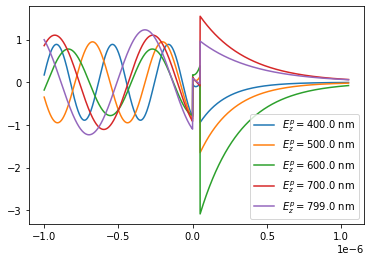

In [17]:
zplot, E_out, zn_plot = gtm.calculate_Efield(r, R, t, T, dz=1e-9) # get the electric field
plt.figure()
i = 0
plt.plot(zplot, np.real(E_out[i, 0, 2, :]), label='$E_z^p=${:0.1f} nm'.format(gtm.wl[i].magnitude))
i = 100
plt.plot(zplot, np.real(E_out[i, 0, 2, :]), label='$E_z^p=${:0.1f} nm'.format(gtm.wl[i].magnitude))
i = 200
plt.plot(zplot, np.real(E_out[i, 0, 2, :]), label='$E_z^p=${:0.1f} nm'.format(gtm.wl[i].magnitude))
i = 300
plt.plot(zplot, np.real(E_out[i, 0, 2, :]), label='$E_z^p=${:0.1f} nm'.format(gtm.wl[i].magnitude))
i = 399
plt.plot(zplot, np.real(E_out[i, 0, 2, :]), label='$E_z^p=${:0.1f} nm'.format(gtm.wl[i].magnitude))
plt.legend()
plt.show()

c:\users\loc_schick\general\python\wpy64-3890\python-3.8.9.amd64\lib\site-packages\matplotlib\cbook\__init__.py:736: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)


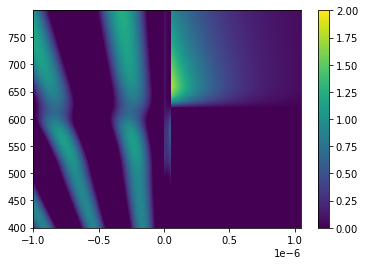

In [18]:
plt.figure()

plt.pcolormesh(zplot, gtm.wl, np.real(E_out[:, 0, 2, :]), vmin=0, vmax=2, shading='auto')
plt.colorbar()

plt.show()

## Air Gap Example

In [19]:
wavenumbers = np.r_[750:1050:1]/u.cm
gtm.wl = 1/wavenumbers #  set the wavelength by wavenumber
#gtm.frequency = gtm.frequency*1e2
gtm.theta =  np.r_[30]*u.deg

c:\users\loc_schick\general\git\udkm1dsim\udkm1Dsim\simulations\scattering.py:258: RuntimeWarning: invalid value encountered in arcsin
  self._theta = np.arcsin(np.outer(self._wl, self._qz[0, :])/np.pi/4)


use pyGTM permittivities

In [20]:
import GTM.permittivities as perm
eps_KRS5 = perm.eps_KRS5
eps_SiC6Hx = perm.eps_SiC6Hx
eps_SiC6Hz = perm.eps_SiC6Hz

In [21]:
layer_KRS5 = ud.AmorphousLayer('KRS5', "KRS5", 1*u.um, 0*u.kg/u.m**3)
layer_KRS5.epsilon = lambda f: eps_KRS5(f)
layer_SiC6H = ud.AmorphousLayer('SiC6H', "SiC6H", 3*u.um, 0*u.kg/u.m**3)
layer_SiC6H.epsilon = [lambda f: eps_SiC6Hx(f), lambda f: eps_SiC6Hx(f), lambda f: eps_SiC6Hz(f)]
layer_air.thickness = 5.5*u.um

build the sample

In [22]:
S = ud.Structure('Optical Sample Gold')
S.add_sub_structure(layer_KRS5, 1)
S.add_sub_structure(layer_air, 1)
S.add_sub_structure(layer_SiC6H, 1)
gtm.S = S

calculate the reflectivity and transmission

In [23]:
r, R, t, T = gtm.calculate_r_t()

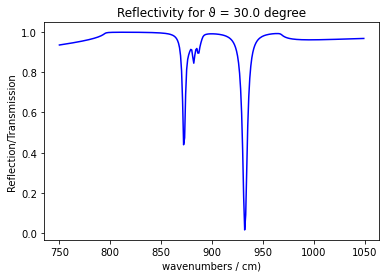

In [24]:
index = 0
plt.figure()
plt.plot(wavenumbers, R[:, index, 0], '-b', label=r'$R_p$')
plt.title('Reflectivity for ϑ = {:0.1f}'.format(gtm.theta[0, index]))
plt.xlabel('wavenumbers / cm)')
plt.ylabel('Reflection/Transmission')
plt.show()

In [25]:
dz = 100e-9 # spatial resolution
zplot, E_out, zn_plot = gtm.calculate_Efield(r, R, t, T, dz=dz)

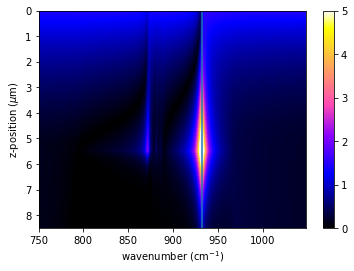

In [26]:
#wnm, zm = np.meshgrid(wavenumbers, zplot*1e6)
fig2ab = plt.figure()

axfield = fig2ab.add_subplot(111)
img = np.abs(E_out[:, 0, 0, :].T)
axc = axfield.pcolormesh(wavenumbers.magnitude, zplot*1e6, img, vmin=0, vmax=5, 
                         shading='gouraud', cmap=plt.cm.gnuplot2)

axfield.invert_yaxis()
axfield.set_xlabel('wavenumber (cm$^{-1}$)')
axfield.set_ylabel('z-position ($\mu$m)')
axfield.set_ylim([8.5, 0])
plt.axvline(932)
fig2ab.colorbar(axc)

plt.show()